# Advanced Data Science with IBM
## Use Case: Fault prediction for gear bearings (anomaly detection)

### Model evaluation

In [89]:
#All import statements
import numpy as np
import json
import pandas as pd
import os, csv, glob, datetime, time
import dill as pickle
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import read_csv
import sklearn
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras import regularizers
from keras.models import load_model
from keras.callbacks import Callback
from keras.layers import LSTM, Dense, Activation
from matplotlib.dates import DateFormatter
from watson_machine_learning_client import WatsonMachineLearningAPIClient

#install pyod for knn outlier detection
!pip install pyod
from pyod.models.knn import KNN   # kNN detector

#to get rid of the warning execute register_matplotlib_converters() 
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from botocore.client import Config
import ibm_boto3
%matplotlib inline

In [90]:
# import of csv files
def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share your notebook.
client_b2d04bb960e541b59bf748286f30fef3 = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='HXB6bIyaokBGw-eWQ7IlD3GvZyZhVYDCePt5uiSYMZnq',
    ibm_auth_endpoint="https://iam.bluemix.net/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')

body = client_b2d04bb960e541b59bf748286f30fef3.get_object(Bucket='courseraadvanceddatascience-donotdelete-pr-eqpoqlvyxje0ta',Key='df_nok.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_nok = pd.read_csv(body)
df_nok.index = pd.DatetimeIndex(df_nok.date)
df_nok = df_nok.drop(['date'], axis=1)

In [91]:
body = client_b2d04bb960e541b59bf748286f30fef3.get_object(Bucket='courseraadvanceddatascience-donotdelete-pr-eqpoqlvyxje0ta',Key='df_ok.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_ok = pd.read_csv(body)
df_ok.index = pd.DatetimeIndex(df_ok.date)
df_ok = df_ok.drop(['date'], axis=1)

#### 1. Loading keras model and history files

In [92]:
# load LSTM model and history file
lstm_model = load_model('lstm_model.h5')
lstm_hist = json.load(open('lstm_hist', 'r'))

# load Dense model and history file
dense_model = load_model('dense_model.h5')
dense_hist = json.load(open('dense_hist', 'r'))

In [93]:
lstm_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 10, 50)            11000     
_________________________________________________________________
lstm_8 (LSTM)                (None, 10, 50)            20200     
_________________________________________________________________
lstm_9 (LSTM)                (None, 10, 50)            20200     
_________________________________________________________________
dense_16 (Dense)             (None, 10, 4)             204       
Total params: 51,604
Trainable params: 51,604
Non-trainable params: 0
_________________________________________________________________


In [94]:
#plot the Loss distributed over the Epochs
def dist_epochs(hist_obj, ylim_max):
    # hist_obj: dictionary object
    # ylim_max: float with max for y-achse

#    ylim_max = max(hist_obj.history['loss'] + lstm_hist.history['val_loss'])
    plt.plot(hist_obj['loss'], 'b', label='Training loss')
    plt.plot(hist_obj['val_loss'], 'r', label='Validation loss')
    plt.ylim([0,ylim_max])
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Loss, [mae]',fontsize=14)
    plt.legend(loc='upper right')
    plt.title('Plot of Training and Validation Loss', fontsize=18)
    plt.show()

In [95]:
def reshape_lstm(df,timesteps,dim=4):
    arr = np.array(df)
    samples=len(arr)
    trim = samples %  timesteps
    reshaped = arr[:samples-trim]
    reshaped.shape = (int((samples-trim)/timesteps),timesteps,dim)
    return reshaped

In [96]:
#plot distribution of scores to find the threshold for the anomaly
def score_dist(score_series, bins,xlim_max):
    # score_series: panda series
    # bins: integer
    # xlim: e.g. 0.5
    
#    xlim_max = max(score_series)  
    plt.figure()
    sns.distplot(score_series,
             bins = bins, 
             kde= True,
            color = 'blue');
    plt.title('Distribution of loss')
    plt.xlim([0.0, xlim_max])

#### 2. Evaluate LSTM model

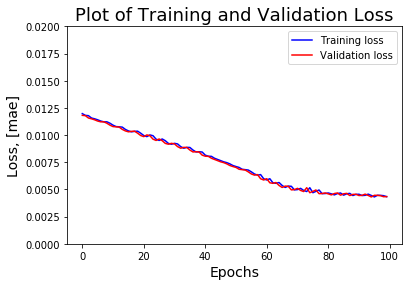

In [97]:
#plot the Loss, distributed over the Epochs
dist_epochs(lstm_hist,0.02)

In [98]:
# reshape the data for LSTM model
lstm_ok = reshape_lstm(df_ok,10,dim=4)
lstm_nok = reshape_lstm(df_nok,10,dim=4)

In [99]:
lstm_ok.shape

(22, 10, 4)

In [100]:
#prediction for OK data
train_prediction = lstm_model.predict(np.array(lstm_ok))
train_pred_reshaped = train_prediction.reshape(lstm_ok.shape[0]*lstm_ok.shape[1],lstm_ok.shape[2])
train_pred_reshaped = pd.DataFrame(train_pred_reshaped, columns=df_ok.columns)
train_pred_reshaped.index = df_ok.index[:lstm_ok.shape[0]*lstm_ok.shape[1]]

#create Panda Series with scores
train_score = pd.DataFrame(index=df_ok.index)
train_score['Loss_mae'] = np.mean(np.abs(train_pred_reshaped-df_ok), axis = 1)

In [101]:
#print max score for estimation of the threshold
print('The maximum score for the training data is {:.2f}'.format(max(train_score['Loss_mae'])))

The maximum score for the training data is 0.38


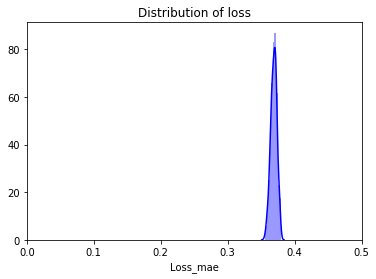

In [102]:
#plot distribution of scores to find the threshold for the anomaly
score_dist(train_score['Loss_mae'], 10,0.5)

In [116]:
#with the info from above analyzes the domain expert needs finally define this threshold for the anomalies
lstm_threshold = 0.375

In [117]:
#create df with classification column and Threshold for train data
train_score['Threshold'] = lstm_threshold   # Domain expert has to define this threshold for the anomalies
train_score['Anomaly'] = train_score['Loss_mae'] > train_score['Threshold']

In [118]:
#prediction for Not OK data
test_prediction = lstm_model.predict(np.array(lstm_nok))
test_pred_reshaped = test_prediction.reshape(750,4)
test_pred_reshaped = pd.DataFrame(test_pred_reshaped, columns=df_nok.columns)
test_pred_reshaped.index = df_nok.index[:750]

#create Panda Series with scores
test_score = pd.DataFrame(index=df_nok.index)
test_score['Loss_mae'] = np.mean(np.abs(test_pred_reshaped-df_nok), axis = 1)

#create df with classification column and Threshold for test data
test_score['Threshold'] = lstm_threshold
test_score['Anomaly'] = test_score['Loss_mae'] > test_score['Threshold']

lstm_score = pd.concat([train_score, test_score])

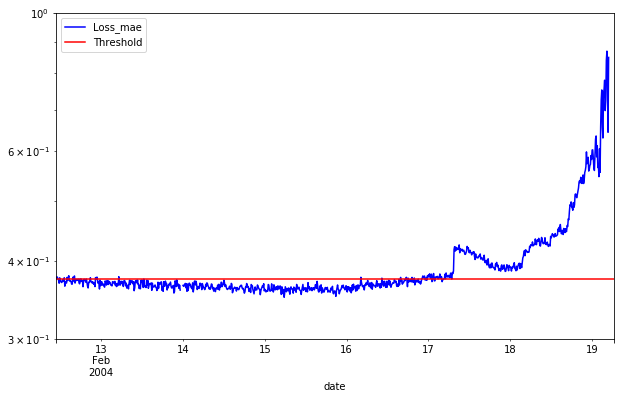

In [119]:
#plot the result
lstm_score.plot(logy=True,  figsize = (10,6), ylim = [3e-1,1e0], color = ['blue','red'])

#### 2. Evaluate Dense model

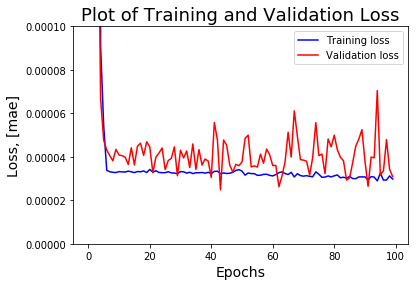

In [123]:
#plot the Loss, distributed over the Epochs
dist_epochs(dense_hist,0.0001)

In [124]:
#prediction for OK data
train_pred_d = dense_model.predict(np.array(df_ok))
train_pred_d = pd.DataFrame(train_pred_d, columns=df_ok.columns)
train_pred_d.index = df_ok.index

#create Panda Series with scores
train_score_d = pd.DataFrame(index=df_ok.index)
train_score_d['Loss_mae'] = np.mean(np.abs(train_pred_d-df_ok), axis = 1)

#print max score for estimation of the threshold
print('The maximum score for the training data is {:.2f}'.format(max(train_score_d['Loss_mae'])))

The maximum score for the training data is 0.36


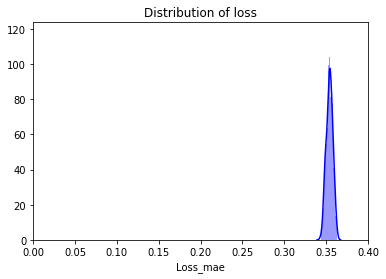

In [126]:
#plot distribution of scores to find the threshold for the anomaly
score_dist(train_score_d['Loss_mae'], 20, 0.40)

In [132]:
#with the info from above analyzes the domain expert needs finally define this threshold for the anomalies
dense_threshold = 0.36

In [133]:
#create df with classification column and Threshold for train data
train_score_d['Threshold'] = dense_threshold   # Domain expert has to define this threshold for the anomalies
train_score_d['Anomaly'] = train_score_d['Loss_mae'] > train_score_d['Threshold']

In [134]:
#prediction for Not OK data
test_pred_d = dense_model.predict(np.array(df_nok))
test_pred_d = pd.DataFrame(test_pred_d, columns=df_nok.columns)
test_pred_d.index = df_nok.index

#create df with classification column and Threshold
test_score_d = pd.DataFrame(index=df_nok.index)
test_score_d['Loss_mae'] = np.mean(np.abs(test_pred_d-df_nok), axis = 1)
test_score_d['Threshold'] = dense_threshold      
test_score_d['Anomaly'] = test_score_d['Loss_mae'] > test_score_d['Threshold']
score_d = pd.concat([train_score_d, test_score_d])

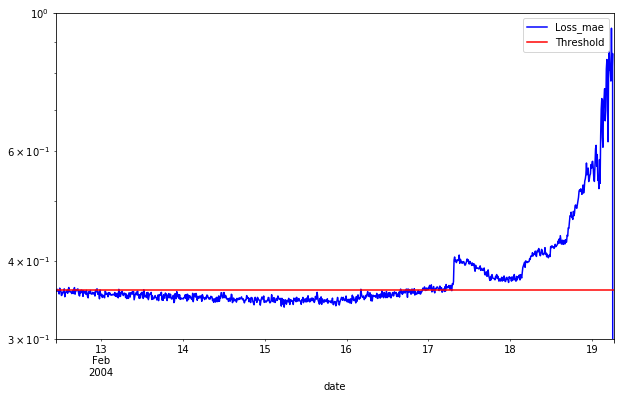

In [143]:
#plot the result
score_d.plot(logy=True,  figsize = (10,6), ylim = [3e-1,1e0], color = ['blue','red'])

#### 3. Create, Train and Evaluate KNN model

In [144]:
# train kNN detector
#clf_name = 'KNN'
clf_knn = KNN(n_neighbors=2, method='median')
clf_knn.fit(df_nok)

# get the prediction label and outlier scores of the training data
y_train_pred = clf_knn.labels_  # binary labels (0: inliers, 1: outliers)
y_train_scores = clf_knn.decision_scores_  # raw outlier scores

# get the prediction on the test data
y_test_pred = clf_knn.predict(df_nok)  # outlier labels (0 or 1)
y_test_scores = clf_knn.decision_function(df_nok)  # outlier scores

In [145]:
clf_knn.threshold_

0.014949806661775162

In [146]:
#create df with classification column and Threshold
test_score_k = pd.DataFrame(index=df_nok.index)
test_score_k['Score'] = y_test_scores
test_score_k['Threshold'] = clf_knn.threshold_      
test_score_k['Anomaly'] = test_score_k['Score'] > test_score_k['Threshold']

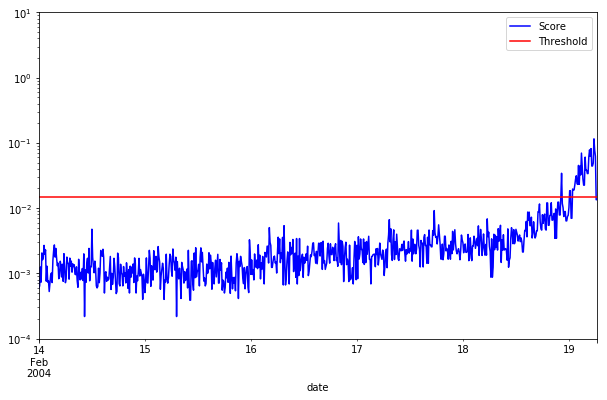

In [147]:
#plot the result
test_score_k.plot(logy=True,  figsize = (10,6), ylim = [1e-4,1e1], color = ['blue','red'])

In [16]:
def train_lstm(data, model, iterations):
    # data: reshaped data array
    # model: lstm model
    #iteration: int with number of training iterations
    
    for i in range(iterations):
        model_lstm = model.fit(data, data, epochs=100, batch_size=72, validation_data=(data, data), verbose=1, shuffle=False)
    return model_lstm

In [17]:
#reshape the dataframe according to the LSTM input shape
def reshape_lstm(df,timesteps,dim=4):
    #df: dataframe
    #timesteps: int with number of timesteps
    #dim: int with number ot timesteps
    
    arr = np.array(df)
    samples=len(arr)
    trim = samples %  timesteps
    reshaped = arr[:samples-trim]
    reshaped.shape = (int((samples-trim)/timesteps),timesteps,dim)
    return reshaped

In [18]:
# reshape the data for LSTM model
lstm_ok = reshape_lstm(df_ok,10,dim=4)
lstm_nok = reshape_lstm(df_nok,10,dim=4)

In [19]:
#details about the number of parameters and output shapes of each layer and an overall model structure
lstm_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 10, 50)            11000     
_________________________________________________________________
lstm_2 (LSTM)                (None, 10, 50)            20200     
_________________________________________________________________
dense_1 (Dense)              (None, 10, 4)             204       
Total params: 31,404
Trainable params: 31,404
Non-trainable params: 0
_________________________________________________________________


In [20]:
# train the model
lstm_hist = train_lstm(lstm_ok,lstm_model,5)

Instructions for updating:
Use tf.cast instead.


2019-08-14 15:24:47,271 - tensorflow - WARNING - From /opt/conda/envs/Python36/lib/python3.6/site-packages/tensorflow/python/ops/math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.


Train on 22 samples, validate on 22 samples
Epoch 1/100
22/22 [==============================] - 5s 212ms/step - loss: 0.3824 - val_loss: 0.3729
Epoch 2/100
22/22 [==============================] - 0s 11ms/step - loss: 0.3729 - val_loss: 0.3618
Epoch 3/100
22/22 [==============================] - 0s 17ms/step - loss: 0.3618 - val_loss: 0.3487
Epoch 4/100
22/22 [==============================] - 0s 10ms/step - loss: 0.3487 - val_loss: 0.3362
Epoch 5/100
22/22 [==============================] - 0s 8ms/step - loss: 0.3362 - val_loss: 0.3231
Epoch 6/100
22/22 [==============================] - 0s 10ms/step - loss: 0.3231 - val_loss: 0.3088
Epoch 7/100
22/22 [==============================] - 0s 9ms/step - loss: 0.3088 - val_loss: 0.2960
Epoch 8/100
22/22 [==============================] - 0s 8ms/step - loss: 0.2960 - val_loss: 0.2848
Epoch 9/100
22/22 [==============================] - 0s 9ms/step - loss: 0.2848 - val_loss: 0.2732
Epoch 10/100
22/22 [==============================] - 0s 9m

Epoch 83/100
22/22 [==============================] - 0s 8ms/step - loss: 0.0480 - val_loss: 0.0475
Epoch 84/100
22/22 [==============================] - 0s 8ms/step - loss: 0.0475 - val_loss: 0.0469
Epoch 85/100
22/22 [==============================] - 0s 12ms/step - loss: 0.0469 - val_loss: 0.0464
Epoch 86/100
22/22 [==============================] - 0s 8ms/step - loss: 0.0464 - val_loss: 0.0459
Epoch 87/100
22/22 [==============================] - 0s 8ms/step - loss: 0.0459 - val_loss: 0.0454
Epoch 88/100
22/22 [==============================] - 0s 8ms/step - loss: 0.0454 - val_loss: 0.0448
Epoch 89/100
22/22 [==============================] - 0s 9ms/step - loss: 0.0448 - val_loss: 0.0443
Epoch 90/100
22/22 [==============================] - 0s 7ms/step - loss: 0.0443 - val_loss: 0.0437
Epoch 91/100
22/22 [==============================] - 0s 8ms/step - loss: 0.0437 - val_loss: 0.0432
Epoch 92/100
22/22 [==============================] - 0s 8ms/step - loss: 0.0432 - val_loss: 0.0427

Epoch 65/100
22/22 [==============================] - 0s 8ms/step - loss: 0.0195 - val_loss: 0.0192
Epoch 66/100
22/22 [==============================] - 0s 8ms/step - loss: 0.0192 - val_loss: 0.0190
Epoch 67/100
22/22 [==============================] - 0s 10ms/step - loss: 0.0190 - val_loss: 0.0188
Epoch 68/100
22/22 [==============================] - 0s 10ms/step - loss: 0.0188 - val_loss: 0.0186
Epoch 69/100
22/22 [==============================] - 0s 8ms/step - loss: 0.0186 - val_loss: 0.0184
Epoch 70/100
22/22 [==============================] - 0s 11ms/step - loss: 0.0184 - val_loss: 0.0183
Epoch 71/100
22/22 [==============================] - 0s 8ms/step - loss: 0.0183 - val_loss: 0.0181
Epoch 72/100
22/22 [==============================] - 1s 41ms/step - loss: 0.0181 - val_loss: 0.0179
Epoch 73/100
22/22 [==============================] - 0s 11ms/step - loss: 0.0179 - val_loss: 0.0177
Epoch 74/100
22/22 [==============================] - 0s 11ms/step - loss: 0.0177 - val_loss: 0

22/22 [==============================] - 0s 11ms/step - loss: 0.0090 - val_loss: 0.0088
Epoch 47/100
22/22 [==============================] - 0s 8ms/step - loss: 0.0088 - val_loss: 0.0088
Epoch 48/100
22/22 [==============================] - 0s 11ms/step - loss: 0.0088 - val_loss: 0.0087
Epoch 49/100
22/22 [==============================] - 0s 8ms/step - loss: 0.0087 - val_loss: 0.0086
Epoch 50/100
22/22 [==============================] - 1s 24ms/step - loss: 0.0086 - val_loss: 0.0085
Epoch 51/100
22/22 [==============================] - 0s 9ms/step - loss: 0.0085 - val_loss: 0.0084
Epoch 52/100
22/22 [==============================] - 0s 18ms/step - loss: 0.0084 - val_loss: 0.0082
Epoch 53/100
22/22 [==============================] - 0s 9ms/step - loss: 0.0082 - val_loss: 0.0082
Epoch 54/100
22/22 [==============================] - 0s 8ms/step - loss: 0.0082 - val_loss: 0.0081
Epoch 55/100
22/22 [==============================] - 0s 8ms/step - loss: 0.0081 - val_loss: 0.0080
Epoch 56/

Epoch 28/100
22/22 [==============================] - 0s 15ms/step - loss: 0.0039 - val_loss: 0.0038
Epoch 29/100
22/22 [==============================] - 0s 8ms/step - loss: 0.0038 - val_loss: 0.0038
Epoch 30/100
22/22 [==============================] - 0s 8ms/step - loss: 0.0038 - val_loss: 0.0038
Epoch 31/100
22/22 [==============================] - 0s 7ms/step - loss: 0.0038 - val_loss: 0.0039
Epoch 32/100
22/22 [==============================] - 0s 9ms/step - loss: 0.0039 - val_loss: 0.0040
Epoch 33/100
22/22 [==============================] - 0s 8ms/step - loss: 0.0040 - val_loss: 0.0039
Epoch 34/100
22/22 [==============================] - 0s 8ms/step - loss: 0.0039 - val_loss: 0.0038
Epoch 35/100
22/22 [==============================] - 0s 10ms/step - loss: 0.0038 - val_loss: 0.0038
Epoch 36/100
22/22 [==============================] - 0s 8ms/step - loss: 0.0038 - val_loss: 0.0040
Epoch 37/100
22/22 [==============================] - 0s 8ms/step - loss: 0.0040 - val_loss: 0.004

Epoch 10/100
22/22 [==============================] - 0s 11ms/step - loss: 0.0039 - val_loss: 0.0041
Epoch 11/100
22/22 [==============================] - 0s 9ms/step - loss: 0.0041 - val_loss: 0.0040
Epoch 12/100
22/22 [==============================] - 0s 8ms/step - loss: 0.0040 - val_loss: 0.0038
Epoch 13/100
22/22 [==============================] - 0s 7ms/step - loss: 0.0038 - val_loss: 0.0038
Epoch 14/100
22/22 [==============================] - 0s 10ms/step - loss: 0.0038 - val_loss: 0.0037
Epoch 15/100
22/22 [==============================] - 0s 8ms/step - loss: 0.0037 - val_loss: 0.0039
Epoch 16/100
22/22 [==============================] - 0s 15ms/step - loss: 0.0039 - val_loss: 0.0041
Epoch 17/100
22/22 [==============================] - 0s 8ms/step - loss: 0.0041 - val_loss: 0.0040
Epoch 18/100
22/22 [==============================] - 0s 9ms/step - loss: 0.0040 - val_loss: 0.0038
Epoch 19/100
22/22 [==============================] - 0s 9ms/step - loss: 0.0038 - val_loss: 0.00

Epoch 92/100
22/22 [==============================] - 0s 13ms/step - loss: 0.0037 - val_loss: 0.0037
Epoch 93/100
22/22 [==============================] - 0s 17ms/step - loss: 0.0037 - val_loss: 0.0037
Epoch 94/100
22/22 [==============================] - 0s 9ms/step - loss: 0.0037 - val_loss: 0.0037
Epoch 95/100
22/22 [==============================] - 0s 11ms/step - loss: 0.0037 - val_loss: 0.0037
Epoch 96/100
22/22 [==============================] - 0s 8ms/step - loss: 0.0037 - val_loss: 0.0038
Epoch 97/100
22/22 [==============================] - 0s 11ms/step - loss: 0.0038 - val_loss: 0.0038
Epoch 98/100
22/22 [==============================] - 0s 7ms/step - loss: 0.0038 - val_loss: 0.0037
Epoch 99/100
22/22 [==============================] - 0s 9ms/step - loss: 0.0037 - val_loss: 0.0037
Epoch 100/100
22/22 [==============================] - 0s 9ms/step - loss: 0.0037 - val_loss: 0.0037


#### 3. Training Dense model

In [21]:
# Modeling - train neural network
def train_NN(data, model,batch_size=10,epochs=100):
    # data: dataframe
    
    history=model.fit(np.array(data),np.array(data),
                      batch_size=batch_size, 
                      epochs=epochs,
                      validation_split=0.05,
                      verbose = 1)
    return history

In [22]:
#details about the number of parameters and output shapes of each layer and an overall model structure
dense_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 10)                50        
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 22        
_________________________________________________________________
dense_4 (Dense)              (None, 10)                30        
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 44        
Total params: 146
Trainable params: 146
Non-trainable params: 0
_________________________________________________________________


In [23]:
dense_hist = train_NN(df_ok, dense_model)

Train on 212 samples, validate on 12 samples
Epoch 1/100
212/212 [==============================] - 1s 6ms/step - loss: 0.0976 - val_loss: 0.0505
Epoch 2/100
212/212 [==============================] - 0s 202us/step - loss: 0.0256 - val_loss: 0.0048
Epoch 3/100
212/212 [==============================] - 0s 191us/step - loss: 0.0014 - val_loss: 5.9907e-04
Epoch 4/100
212/212 [==============================] - 0s 234us/step - loss: 2.2009e-04 - val_loss: 3.2002e-05
Epoch 5/100
212/212 [==============================] - 0s 205us/step - loss: 4.0138e-05 - val_loss: 1.7200e-05
Epoch 6/100
212/212 [==============================] - 0s 216us/step - loss: 2.3972e-05 - val_loss: 3.8277e-05
Epoch 7/100
212/212 [==============================] - 0s 222us/step - loss: 2.3803e-05 - val_loss: 2.7774e-05
Epoch 8/100
212/212 [==============================] - 0s 200us/step - loss: 2.3721e-05 - val_loss: 2.8733e-05
Epoch 9/100
212/212 [==============================] - 0s 195us/step - loss: 2.3584e-05 -

212/212 [==============================] - 0s 223us/step - loss: 2.2879e-05 - val_loss: 2.5535e-05
Epoch 75/100
212/212 [==============================] - 0s 202us/step - loss: 2.3406e-05 - val_loss: 3.7009e-05
Epoch 76/100
212/212 [==============================] - 0s 200us/step - loss: 2.3012e-05 - val_loss: 2.4226e-05
Epoch 77/100
212/212 [==============================] - 0s 464us/step - loss: 2.2564e-05 - val_loss: 2.3936e-05
Epoch 78/100
212/212 [==============================] - 0s 203us/step - loss: 2.3644e-05 - val_loss: 2.4676e-05
Epoch 79/100
212/212 [==============================] - 0s 202us/step - loss: 2.2863e-05 - val_loss: 2.5262e-05
Epoch 80/100
212/212 [==============================] - 0s 244us/step - loss: 2.3027e-05 - val_loss: 3.1311e-05
Epoch 81/100
212/212 [==============================] - 0s 199us/step - loss: 2.3059e-05 - val_loss: 3.8223e-05
Epoch 82/100
212/212 [==============================] - 0s 203us/step - loss: 2.3106e-05 - val_loss: 2.8010e-05
Epoch

#### 4. Training KNN model

In [45]:
from sklearn.externals import joblib
# Load from file
#joblib_file = "joblib_model.pkl"
joblib_model = joblib.load('joblib_model.pkl')


In [46]:
joblib_model.predict(df_nok)

AttributeError: 'str' object has no attribute 'predict'

In [10]:
print(lstm_hist.keys())

dict_keys(['val_loss', 'loss'])


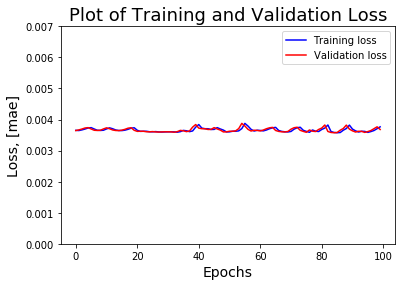

In [70]:
#plot the Loss, distributed over the Epochs
dist_epochs(lstm_hist,0.007)

In [71]:
lstm_ok.shape

(22, 10, 4)

/opt/conda/envs/Python36/lib/python3.6/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/conda/envs/Python36/lib/python3.6/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


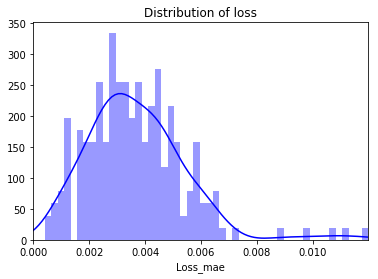

In [72]:
#prediction for OK data
train_prediction = lstm_model.predict(np.array(lstm_ok))
train_pred_reshaped = train_prediction.reshape(lstm_ok.shape[0]*lstm_ok.shape[1],lstm_ok.shape[2])
train_pred_reshaped = pd.DataFrame(train_pred_reshaped, columns=df_ok.columns)
train_pred_reshaped.index = df_ok.index[:lstm_ok.shape[0]*lstm_ok.shape[1]]

#create Panda Series with scores
train_score = pd.DataFrame(index=df_ok.index)
train_score['Loss_mae'] = np.mean(np.abs(train_pred_reshaped-df_ok), axis = 1)

#plot distribution of scores to find the threshold for the anomaly
score_dist(train_score['Loss_mae'], 50)

In [73]:
#min score from training data
print(max(train_score['Loss_mae']))

0.011968765510954785


In [74]:
#with the info from above analyzes the domain expert needs finally define this threshold for the anomalies
lstm_threshold = 0.013 

In [75]:
#create df with classification column and Threshold for train data
train_score['Threshold'] = lstm_threshold   # Domain expert has to define this threshold for the anomalies
train_score['Anomaly'] = train_score['Loss_mae'] > train_score['Threshold']

In [76]:
#prediction for Not OK data
test_prediction = lstm_model.predict(np.array(lstm_nok))
test_pred_reshaped = test_prediction.reshape(750,4)
test_pred_reshaped = pd.DataFrame(test_pred_reshaped, columns=df_nok.columns)
test_pred_reshaped.index = df_nok.index[:750]

#create Panda Series with scores
test_score = pd.DataFrame(index=df_nok.index)
test_score['Loss_mae'] = np.mean(np.abs(test_pred_reshaped-df_nok), axis = 1)

#create df with classification column and Threshold for test data
test_score['Threshold'] = lstm_threshold
test_score['Anomaly'] = test_score['Loss_mae'] > test_score['Threshold']

lstm_score = pd.concat([train_score, test_score])

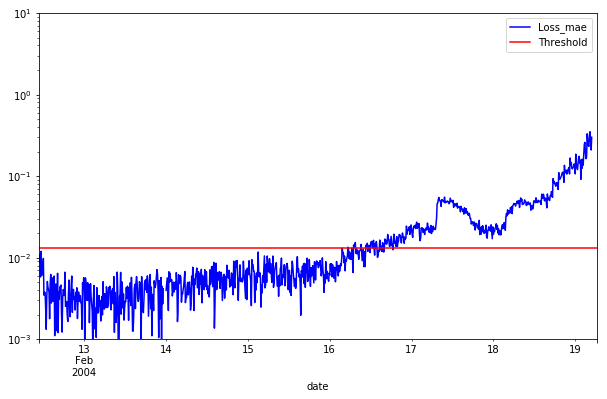

In [77]:
#plot the result
lstm_score.plot(logy=True,  figsize = (10,6), ylim = [1e-3,1e1], color = ['blue','red'])

### Model 1 - Neural Network - Dense Autoencoder

In [86]:
# Modeling - design neural network
def create_model_NN(df):
    act_func = 'elu'
    model = Sequential()
    model.add(Dense(10,activation=act_func,
                    kernel_initializer='glorot_uniform',
                    kernel_regularizer=regularizers.l2(0.0),
                    input_shape=(df.shape[1],)))
    model.add(Dense(2,activation=act_func, kernel_initializer='glorot_uniform'))
    model.add(Dense(10,activation=act_func, kernel_initializer='glorot_uniform'))
    model.add(Dense(df.shape[1], kernel_initializer='glorot_uniform'))

    model.compile(loss='mse', optimizer='adam')
    return model

In [87]:
# Modeling - train neural network
def train_NN(data, model,batch_size=10,epochs=100):
    # data: dataframe
    
    history=model.fit(np.array(data),np.array(data),
                      batch_size=batch_size, 
                      epochs=epochs,
                      validation_split=0.05,
                      verbose = 1)
    return history

In [88]:
#train the model
dense_model = create_model_NN(df_ok)
dense_hist = train_NN(df_ok, dense_model)

Train on 212 samples, validate on 12 samples
Epoch 1/100
212/212 [==============================] - 1s 6ms/step - loss: 0.1351 - val_loss: 0.0889
Epoch 2/100
212/212 [==============================] - 0s 206us/step - loss: 0.0639 - val_loss: 0.0347
Epoch 3/100
212/212 [==============================] - 0s 194us/step - loss: 0.0228 - val_loss: 0.0101
Epoch 4/100
212/212 [==============================] - 0s 228us/step - loss: 0.0060 - val_loss: 0.0016
Epoch 5/100
212/212 [==============================] - 0s 190us/step - loss: 8.3719e-04 - val_loss: 6.4285e-05
Epoch 6/100
212/212 [==============================] - 0s 199us/step - loss: 7.2698e-05 - val_loss: 4.4353e-05
Epoch 7/100
212/212 [==============================] - 0s 224us/step - loss: 3.7243e-05 - val_loss: 5.0709e-05
Epoch 8/100
212/212 [==============================] - 0s 200us/step - loss: 3.6409e-05 - val_loss: 4.3938e-05
Epoch 9/100
212/212 [==============================] - 0s 212us/step - loss: 3.5863e-05 - val_loss: 3

Epoch 74/100
212/212 [==============================] - 0s 217us/step - loss: 3.5594e-05 - val_loss: 3.7233e-05
Epoch 75/100
212/212 [==============================] - 0s 189us/step - loss: 3.6226e-05 - val_loss: 4.7182e-05
Epoch 76/100
212/212 [==============================] - 0s 185us/step - loss: 3.5976e-05 - val_loss: 3.4616e-05
Epoch 77/100
212/212 [==============================] - 0s 184us/step - loss: 3.5913e-05 - val_loss: 4.2891e-05
Epoch 78/100
212/212 [==============================] - 0s 196us/step - loss: 3.5636e-05 - val_loss: 3.6736e-05
Epoch 79/100
212/212 [==============================] - 0s 167us/step - loss: 3.5827e-05 - val_loss: 4.0245e-05
Epoch 80/100
212/212 [==============================] - 0s 212us/step - loss: 3.5703e-05 - val_loss: 3.9109e-05
Epoch 81/100
212/212 [==============================] - 0s 175us/step - loss: 3.5671e-05 - val_loss: 3.8878e-05
Epoch 82/100
212/212 [==============================] - 0s 196us/step - loss: 3.5616e-05 - val_loss: 3.8

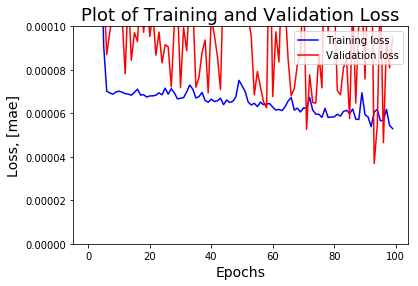

In [19]:
#plot the Loss, distributed over the Epochs
dist_epochs(dense_hist,0.0001)

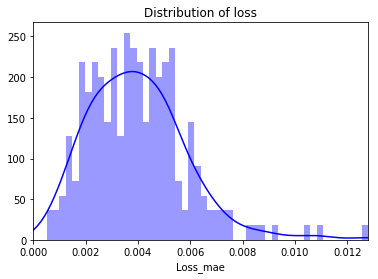

In [38]:
#prediction for OK data
train_pred_d = dense_model.predict(np.array(df_ok))
train_pred_d = pd.DataFrame(train_pred_d, columns=df_ok.columns)
train_pred_d.index = df_ok.index

#create Panda Series with scores
train_score_d = pd.DataFrame(index=df_ok.index)
train_score_d['Loss_mae'] = np.mean(np.abs(train_pred_d-df_ok), axis = 1)

#plot distribution of scores to find the threshold for the anomaly
score_dist(train_score_d['Loss_mae'], 50)

In [39]:
#min score from training data
print(max(train_score_d['Loss_mae']))

0.012787896016426534


In [40]:
#with the info from above analyzes the domain expert needs finally define this threshold for the anomalies
dense_threshold = 0.015

In [41]:
#create df with classification column and Threshold for train data
train_score_d['Threshold'] = dense_threshold   # Domain expert has to define this threshold for the anomalies
train_score_d['Anomaly'] = train_score_d['Loss_mae'] > train_score_d['Threshold']

In [42]:
#prediction for Not OK data
test_pred_d = dense_model.predict(np.array(df_nok))
test_pred_d = pd.DataFrame(test_pred_d, columns=df_nok.columns)
test_pred_d.index = df_nok.index

#create df with classification column and Threshold
test_score_d = pd.DataFrame(index=df_nok.index)
test_score_d['Loss_mae'] = np.mean(np.abs(test_pred_d-df_nok), axis = 1)
test_score_d['Threshold'] = dense_threshold      
test_score_d['Anomaly'] = test_score_d['Loss_mae'] > test_score_d['Threshold']
score_d = pd.concat([train_score_d, test_score_d])

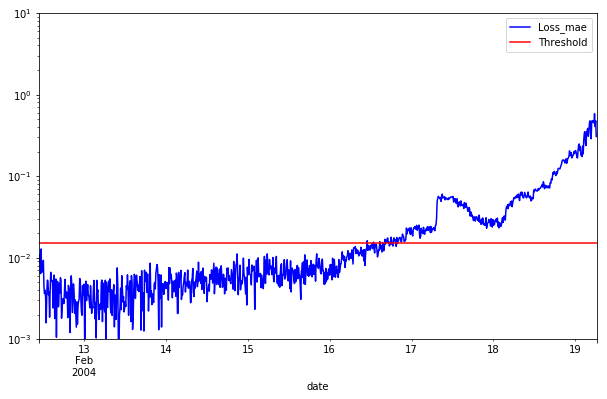

In [43]:
#plot the result
score_d.plot(logy=True,  figsize = (10,6), ylim = [1e-3,1e1], color = ['blue','red'])

### Model 3 - KNN

In [4]:
# train kNN detector
#clf_name = 'KNN'
clf_knn = KNN(n_neighbors=20, method='median')
clf_knn.fit(df_nok)

# get the prediction label and outlier scores of the training data
y_train_pred = clf_knn.labels_  # binary labels (0: inliers, 1: outliers)
y_train_scores = clf_knn.decision_scores_  # raw outlier scores

# get the prediction on the test data
y_test_pred = clf_knn.predict(df_nok)  # outlier labels (0 or 1)
y_test_scores = clf_knn.decision_function(df_nok)  # outlier scores

In [89]:
clf_knn.threshold_

0.038317646409085096

In [90]:
#create df with classification column and Threshold
test_score_k = pd.DataFrame(index=df_nok.index)
test_score_k['Score'] = y_test_scores
test_score_k['Threshold'] = clf_knn.threshold_      
test_score_k['Anomaly'] = test_score_k['Score'] > test_score_k['Threshold']

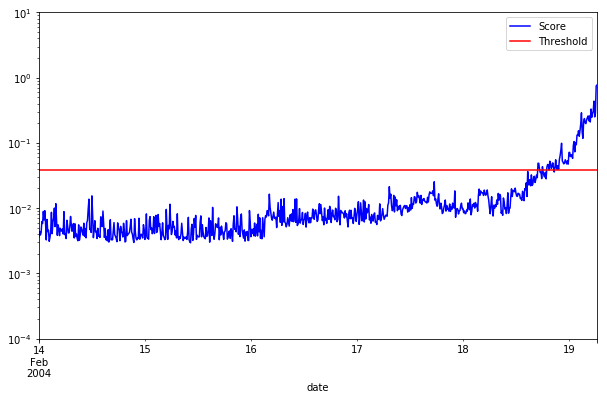

In [91]:
#plot the result
test_score_k.plot(logy=True,  figsize = (10,6), ylim = [1e-4,1e1], color = ['blue','red'])

### Save models

In [62]:
#!pip install watson-machine-learning-client

In [80]:
#to make authenticated requests to IBM Watson™ services an IAM token needs to be created
#https://cloud.ibm.com/docs/services/watson?topic=watson-iam

wml_credentials = {
  "apikey": "HTJqOJxqciFoK_m9FWq0mO2GuYtp6AIUGB2MnKJwEq7I",
  "iam_apikey_description": "Auto-generated for key b3b24467-0076-4aa9-9128-cbb1b55bbb69",
  "iam_apikey_name": "Service credentials-1",
  "iam_role_crn": "crn:v1:bluemix:public:iam::::serviceRole:Writer",
  "iam_serviceid_crn": "crn:v1:bluemix:public:iam-identity::a/c9264c02fc8b40c1987a417a0eee708a::serviceid:ServiceId-343dea06-9c35-4caf-a227-28759bf85d25",
  "instance_id": "7d33421f-5277-47be-8de2-03d6de4ebf37",
  "url": "https://us-south.ml.cloud.ibm.com"
}

client = WatsonMachineLearningAPIClient(wml_credentials)

In [64]:
#get version of keras
!pip show keras

Name: Keras
Version: 2.2.4
Summary: Deep Learning for humans
Home-page: https://github.com/keras-team/keras
Author: Francois Chollet
Author-email: francois.chollet@gmail.com
License: MIT
Location: /opt/conda/envs/Python36/lib/python3.6/site-packages
Requires: numpy, scipy, six, pyyaml, h5py, keras-applications, keras-preprocessing
Required-by: 


In [65]:
#get version of tensorflow
!pip show tensorflow

Name: tensorflow
Version: 1.13.1
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: opensource@google.com
License: Apache 2.0
Location: /opt/conda/envs/Python36/lib/python3.6/site-packages
Requires: grpcio, keras-applications, tensorboard, protobuf, wheel, absl-py, six, termcolor, astor, gast, keras-preprocessing, tensorflow-estimator, numpy
Required-by: 


In [66]:
#get the meta information for the models
client.repository.ModelMetaNames.get()

['AUTHOR_NAME',
 'DESCRIPTION',
 'EVALUATION_METHOD',
 'EVALUATION_METRICS',
 'FRAMEWORK_LIBRARIES',
 'FRAMEWORK_NAME',
 'FRAMEWORK_VERSION',
 'INPUT_DATA_SCHEMA',
 'LABEL_FIELD',
 'NAME',
 'OUTPUT_DATA_SCHEMA',
 'RUNTIME_NAME',
 'RUNTIME_UID',
 'RUNTIME_VERSION',
 'TRAINING_DATA_REFERENCE',
 'TRAINING_DATA_SCHEMA',
 'TRAINING_DEFINITION_URL',
 'TRANSFORMED_LABEL_FIELD']

In [81]:
metadata = {
        client.repository.ModelMetaNames.NAME: 'bearings anomaly detection',
        client.repository.ModelMetaNames.FRAMEWORK_LIBRARIES: [{'name':'keras', 'version': '2.2.4'}],        
        client.repository.ModelMetaNames.FRAMEWORK_NAME: 'tensorflow',
        client.repository.ModelMetaNames.FRAMEWORK_VERSION: '1.13',
        client.repository.ModelMetaNames.RUNTIME_NAME: 'python',
        client.repository.ModelMetaNames.RUNTIME_VERSION: '3.6'
}

In [89]:
dense_model.save("test_dense.h5")

In [91]:
from keras.models import load_model
# load model
test_model = load_model('test_dense.h5')

In [92]:
dense_hist = train_NN(df_ok, test_model)

Train on 212 samples, validate on 12 samples
Epoch 1/100
212/212 [==============================] - 1s 4ms/step - loss: 3.5685e-05 - val_loss: 4.2387e-05
Epoch 2/100
212/212 [==============================] - 0s 219us/step - loss: 3.5472e-05 - val_loss: 3.6782e-05
Epoch 3/100
212/212 [==============================] - 0s 204us/step - loss: 3.5252e-05 - val_loss: 4.2188e-05
Epoch 4/100
212/212 [==============================] - 0s 234us/step - loss: 3.6067e-05 - val_loss: 4.3296e-05
Epoch 5/100
212/212 [==============================] - 0s 200us/step - loss: 3.6058e-05 - val_loss: 4.2871e-05
Epoch 6/100
212/212 [==============================] - 0s 201us/step - loss: 3.6339e-05 - val_loss: 3.8823e-05
Epoch 7/100
212/212 [==============================] - 0s 201us/step - loss: 3.5973e-05 - val_loss: 3.8268e-05
Epoch 8/100
212/212 [==============================] - 0s 233us/step - loss: 3.6219e-05 - val_loss: 4.2891e-05
Epoch 9/100
212/212 [==============================] - 0s 200us/step 

Epoch 74/100
212/212 [==============================] - 0s 196us/step - loss: 3.5281e-05 - val_loss: 3.4096e-05
Epoch 75/100
212/212 [==============================] - 0s 195us/step - loss: 3.4451e-05 - val_loss: 4.8178e-05
Epoch 76/100
212/212 [==============================] - 0s 198us/step - loss: 3.4782e-05 - val_loss: 3.4501e-05
Epoch 77/100
212/212 [==============================] - 0s 195us/step - loss: 3.4253e-05 - val_loss: 3.9424e-05
Epoch 78/100
212/212 [==============================] - 0s 196us/step - loss: 3.7448e-05 - val_loss: 4.9442e-05
Epoch 79/100
212/212 [==============================] - 0s 225us/step - loss: 3.4878e-05 - val_loss: 2.6172e-05
Epoch 80/100
212/212 [==============================] - 0s 191us/step - loss: 3.6068e-05 - val_loss: 3.5090e-05
Epoch 81/100
212/212 [==============================] - 0s 213us/step - loss: 3.5102e-05 - val_loss: 6.4740e-05
Epoch 82/100
212/212 [==============================] - 0s 208us/step - loss: 3.6715e-05 - val_loss: 4.3

In [97]:
#Deploy LSTM model
model_result_path = "lstm_model.h5"
lstm_model.save(model_result_path)
!tar -zcvf lstm_model.tgz lstm_model.h5

lstm_model.h5


In [68]:
#Deploy Dense model
model_result_path = "dense_model.h5"
dense_model.save(model_result_path)
!tar -zcvf dense_model.tgz dense_model.h5

dense_model.h5


In [8]:
# save the KNN model to disk
knn_model = 'knn_model.sav'
pickle.dump(knn_model, open(knn_model, 'wb'))

In [ ]:
test_hist = train_NN(df_ok, dense_model)

In [69]:
lstm_model = client.repository.store_model(model= 'lstm_model.tgz', meta_props=metadata)
dense_model = client.repository.store_model(model= 'dense_model.tgz', meta_props=metadata)

### Model Deployment

In [ ]:
#load KNN model
loaded_model = pickle.load(open('knn_model.sav', 'rb'))

## Summary